<div style="background-color: #8B0000; padding: 20px; border-radius: 10px; text-align: center;">
    <h1 style="color: white; font-size: 50px; margin: 0;">EDA</h1>
</div>

<div style="background-color: #f8f9fa; padding: 15px; border-radius: 10px; width: 60%; margin: auto; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);">
    <h2 style="color: #333; text-align: center;">CONTENIDOS</h2>
    <hr style="border: 1px solid #ccc;">
    <ul style="list-style-type: none; padding-left: 0; font-size: 18px;">
        <li><a href="#id1" style="text-decoration: none; color: #007bff;">1. Exploración y procesamiento de los datos</a></li>
        <li><a href="#id2" style="text-decoration: none; color: #007bff;">1.1 Datos uso BiciMAD</a></li>        
        <li><a href="#id3" style="text-decoration: none; color: #007bff;">1.2 Datos distritos</a></li>
        <li><a href="#id4" style="text-decoration: none; color: #007bff;">1.3 Datos poblacionales</a></li>
        <li><a href="#id5" style="text-decoration: none; color: #007bff;">2. Resultados 
        <li><a href="#id6" style="text-decoration: none; color: #007bff;">3. Conclusiones</a></li>
</ul>
</div>


<div id="id1" style="background-color: #F5F5F5; padding: 15px; border-radius: 10px;">
    <h2 style="color: darkred;">1. EXPLORACIÓN Y PROCESAMIENTO DE LOS DATOS</h2>
</div>

<div id="id2" style="background-color: #F5F5F5; padding: 15px; border-radius: 10px;">
    <h2 style="color: darkred;">1.1 Datos de uso BICIMAD</h2>
</div>

In [ ]:
# Librerías utilizadas
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from shapely.geometry import Point
import seaborn as sns

En primer lugar, el procesado y depuración de los datos de bicimad se ha realizado con el código que se puede encontrar en el siguiente enlace: X

Una vez ya los tenemos depurados y filtrados, se cargan y se empieza a trabajar con ellos.

In [99]:
base_path = Path().resolve()

# Rutas base
excel_folder = base_path / "INPUT" / "datos_filtrados"
excel_files = list(excel_folder.glob("*.xlsx"))

dfs = []
for i, file in enumerate(excel_files):
    df = pd.read_excel(file)
    dfs.append(df)
    print(f"Cargado {file.name} con {len(df)} filas.")
    if i == 0:
        print(f"\nVista previa (head) de {file.name}:")
        print(df.head())

df_concatenado = pd.concat(dfs, ignore_index=True)
print(f"\nTotal filas combinadas de Excel: {len(df_concatenado)}")

Cargado 202201_filtrada.xlsx con 7920 filas.

Vista previa (head) de 202201_filtrada.xlsx:
                timestamp  id                name  total_bases  free_bases  \
0 2022-11-01 14:19:42.605   1    Puerta del Sol A           30           9   
1 2022-11-01 14:19:42.605   2    Puerta del Sol B           30          13   
2 2022-11-01 14:19:42.605   3         Miguel Moya           24          15   
3 2022-11-01 14:19:42.605   4  Plaza Conde Suchil           18          12   
4 2022-11-01 14:19:42.605   5            Malasaña           24          12   

   in_use number  longitude   latitude  \
0    21.5     1a  -3.701834  40.417214   
1    21.0     1b  -3.701603  40.417313   
2     6.0      2  -3.705842  40.420589   
3     6.0      3  -3.706917  40.430294   
4     8.5      4  -3.702587  40.428552   

                                    address  dock_bikes weekday  
0                       Puerta del Sol nº 1          20  Martes  
1                       Puerta del Sol nº 1          17

Como se puede observar, cada estación cuenta con coordenadas geográficas que permiten su geolocalización precisa. Esta información es fundamental ya que facilita la extracción de cada estación en un archivo shapefile.

In [23]:
# Eliminar duplicados por latitud y longitud
df_unicos = df_concatenado.drop_duplicates(subset=["latitude", "longitude"])

# Crear geometría
geometry = [Point(xy) for xy in zip(df_unicos["longitude"], df_unicos["latitude"])]

# Crear GeoDataFrame
gdf_estaciones_excel = gpd.GeoDataFrame(df_unicos, geometry=geometry, crs="EPSG:4326")

# Ruta de salida
output_path = base_path / "OUTPUT"
output_path.mkdir(exist_ok=True)
shp_output_file = output_path / "estaciones.shp"

# Exportar a SHP
gdf_estaciones_excel.to_file(shp_output_file)

print(f"\n Shapefile exportado correctamente a: {shp_output_file}")
print(f" Estaciones únicas exportadas: {len(gdf_estaciones_excel)}")



✅ Shapefile exportado correctamente a: C:\Users\julia\Desktop\program_final\OUTPUT\estaciones.shp
📌 Estaciones únicas exportadas: 307


C:\Users\julia\AppData\Local\Temp\ipykernel_45052\3451398019.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_estaciones_excel.to_file(shp_output_file)
C:\Users\julia\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field timestamp create as date field, though DateTime requested.
  ogr_write(
C:\Users\julia\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_bases' to 'total_base'
  ogr_write(


El conteo nos devuelve 307 estaciones cuando, según la página de [EMT](https://www.emtmadrid.es/Noticias/Continua-el-crecimiento-de-bicimad-el-sistema-se.aspx), deberían existir 650. 

<div id="id3" style="background-color: #F5F5F5; padding: 15px; border-radius: 10px;">
    <h2 style="color: darkred;">1.2 Datos de distritos</h2>
</div>

En cuanto a los datos espaciales, se han obtenido los distritos de Madrid.

In [4]:
# Leer shapefile de distritos
dist2023_folder = base_path / "INPUT" / "dist2023"
dist2023_shps = list(dist2023_folder.glob("*.shp"))

if not dist2023_shps:
    raise FileNotFoundError(f"No se encontraron archivos .shp en {dist2023_folder}")
gdf_dist2023 = gpd.read_file(dist2023_shps[0])
print(f"Leído shapefile de dist2023: {dist2023_shps[0].name}")

Leído shapefile de dist2023: distr2023.shp


In [5]:
# Rutas base
base_path = Path().resolve()
dist_path = base_path / "INPUT" / "dist2023"

# Cargar shapefiles
dist_shp = list(dist_path.glob("*.shp"))[0]
gdf_dist = gpd.read_file(dist_shp)

# Mostrar info de distritos
print(f"\n--- {dist_shp.name} ---")
print("Columnas:", list(gdf_dist.columns))
print(f"Filas: {len(gdf_dist)}")
print("Tipo geometría:", gdf_dist.geom_type.unique())
print(gdf_dist.head())


--- distr2023.shp ---
Columnas: ['CMUN', 'CDDISTRI', 'DSDISTRITO', 'BUSCA', 'ETIQUETA', 'DESCR', 'CDDISTRITO', 'geometry']
Filas: 246
Tipo geometría: ['Polygon' 'MultiPolygon']
  CMUN CDDISTRI DSDISTRITO            BUSCA  ETIQUETA   DESCR CDDISTRITO  \
0  083       01       None  083-01 Distrito  083 - 01  083-01      08301   
1  169       01       None  169-01 Distrito  169 - 01  169-01      16901   
2  123       01       None  123-01 Distrito  123 - 01  123-01      12301   
3  178       01       None  178-01 Distrito  178 - 01  178-01      17801   
4  015       01       None  015-01 Distrito  015 - 01  015-01      01501   

                                            geometry  
0  POLYGON ((472223.182 4493833.429, 472822.824 4...  
1  POLYGON ((446845.622 4517760.008, 446853.422 4...  
2  POLYGON ((456587.747 4473361.856, 456586.547 4...  
3  POLYGON ((406558.082 4473071.751, 406567.082 4...  
4  POLYGON ((423442.309 4461943.402, 423446.509 4...  


Como se aprecia que el archivo contienen mucha información irrelevante para el análisis, se procede a su depuración.

In [6]:
# Mantener solo las columnas necesarias
gdf_dist_simp = gdf_dist[["CMUN", "CDDISTRI", "geometry"]]

# Vista previa
print(gdf_dist_simp.head())

  CMUN CDDISTRI                                           geometry
0  083       01  POLYGON ((472223.182 4493833.429, 472822.824 4...
1  169       01  POLYGON ((446845.622 4517760.008, 446853.422 4...
2  123       01  POLYGON ((456587.747 4473361.856, 456586.547 4...
3  178       01  POLYGON ((406558.082 4473071.751, 406567.082 4...
4  015       01  POLYGON ((423442.309 4461943.402, 423446.509 4...


Se visualiza

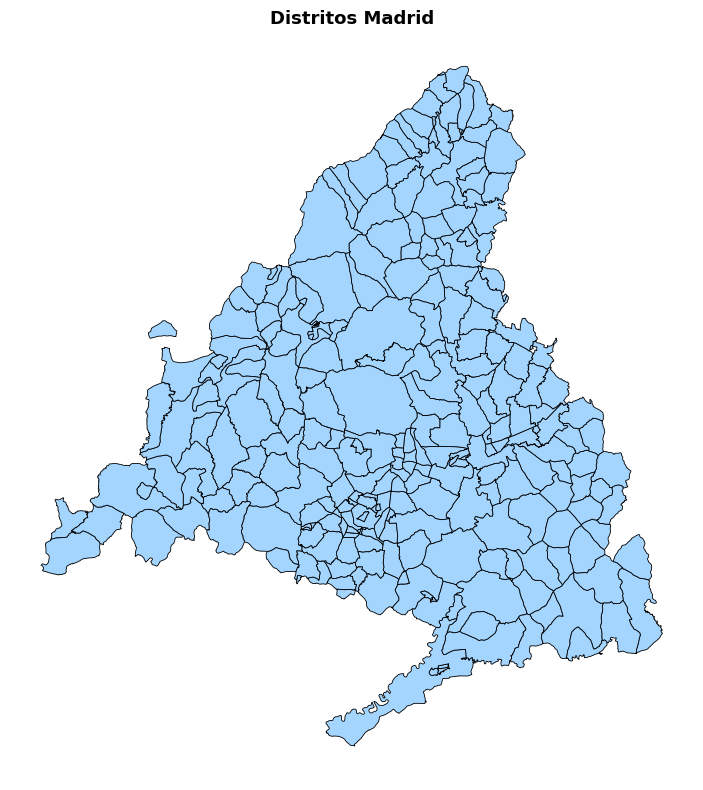

In [9]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar distritos
gdf_dist_simp.plot(ax=ax, edgecolor='black', facecolor='#a3d5ff', linewidth=0.6)

# Ajustes del gráfico
ax.set_title("Distritos Madrid", fontsize=13, fontweight="bold")
ax.axis('off')

# Mostrar
plt.tight_layout()
plt.show()


Se advierte que el archivo recopila todos los distritos, incluso aquellos que no nos hacen falta por no hacer referencia exclusiva a Madrid ciudad por lo que se selecciona aquellos distritos que unicamente tienen relevancia en el estudio y se incluyen las estaciones. 

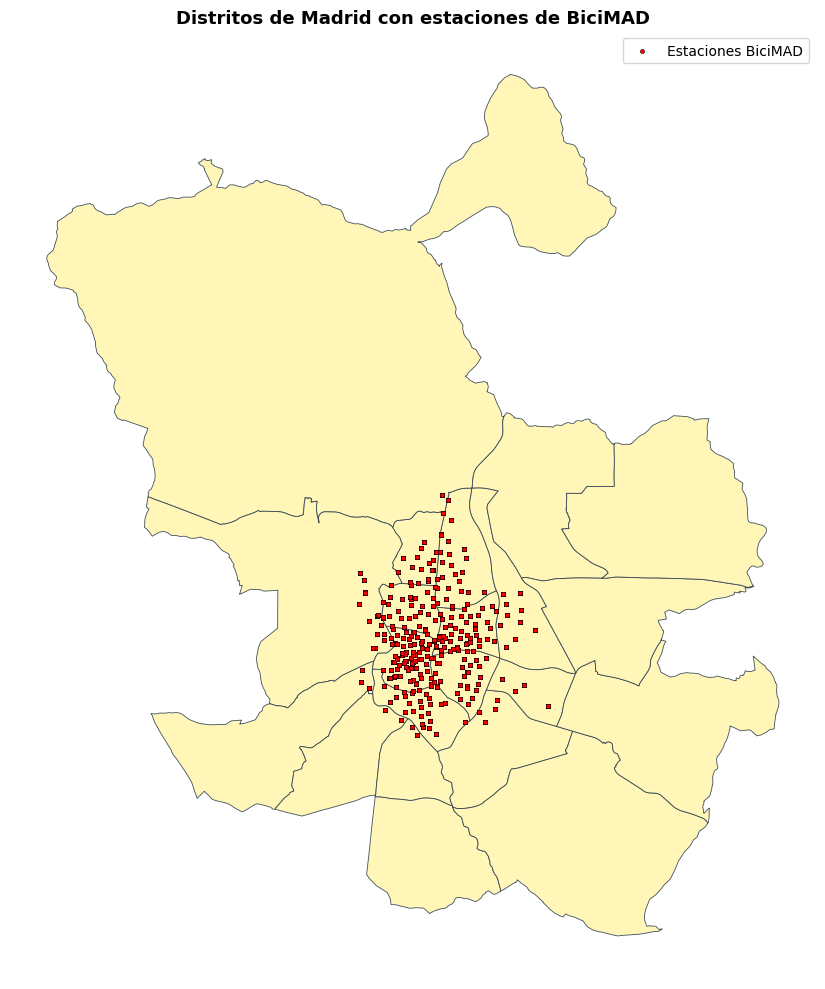

In [14]:
# Rutas base
base_path = Path().resolve()
output_path = base_path / "OUTPUT"
shp_estaciones_excel = output_path / "estaciones.shp"

# Leer shp de estaciones extraído anteriormente 
gdf_estaciones_excel = gpd.read_file(shp_estaciones_excel)

# Filtrar solo distritos de Madrid 
gdf_madrid = gdf_dist_simp[gdf_dist_simp["CMUN"] == "079"]

# Asegurar el mismo sistema de referencia
if gdf_estaciones_excel.crs != gdf_madrid.crs:
    gdf_estaciones_excel = gdf_estaciones_excel.to_crs(gdf_madrid.crs)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))

gdf_madrid.plot(ax=ax, edgecolor="#2c3e50", facecolor="#fff5b1", linewidth=0.6, alpha=0.9)
gdf_estaciones_excel.plot(
    ax=ax,
    color='red',
    markersize=10,
    edgecolor='black',
    linewidth=0.3,
    label='Estaciones BiciMAD'
)

# Título y ajustes
ax.set_title("Distritos de Madrid con estaciones de BiciMAD", fontsize=13, fontweight="bold")
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

<div id="id4" style="background-color: #F5F5F5; padding: 15px; border-radius: 10px;">
    <h2 style="color: darkred;">2.3 Datos poblacionales</h2>
</div>

Para los datos poblacionales, se ha escogido el año 2023 como referencia ya que las estadísticas oficiales recogen la población empadronada a fecha 1 de enero. Esto implica que, en realidad, los datos reflejan la situación demográfica correspondiente al cierre del año 2022. Esta decisión permite mantener la coherencia temporal con el resto de variables analizadas, facilitando una interpretación adecuada en el contexto del modelo de predicción.

In [29]:
# Ruta base
base_path = Path().resolve()
input_path = base_path / "INPUT"

# Buscar archivos CSV dentro de INPUT
csv_files = list(input_path.glob("*.csv"))

# Verificación
if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo CSV en la carpeta INPUT.")

# Cargar el primer archivo CSV
csv_path = csv_files[0]
df_csv = pd.read_csv(csv_path, encoding="latin1")  # o "cp1252"

# Mostrar resultados
print(f"✅ CSV cargado automáticamente: {csv_path.name}")
print(f"Filas: {len(df_csv)} | Columnas: {len(df_csv.columns)}")
print(df_csv.head())

✅ CSV cargado automáticamente: pob_dist.csv
Filas: 21 | Columnas: 1
  cod_distr;distrito;pob_total
0           01; Centro;139.682
1       02; Arganzuela;152.638
2           03; Retiro;117.672
3        04; Salamanca;145.457
4        05; Chamartín;144.371


Se advierte que el archivo se encuentra listo para su uso en el análisis ya que contiene las columnas necesarias y en el formato adecuado.

A continuación, se procede a unir con los distritos para tener la población por distrito en el archivo shapefile.

In [74]:
# Leer el CSV
df_csv = pd.read_csv(csv_path, encoding="latin1", sep=';')

# Convertir columnas a string y rellenar con ceros
gdf_dist_simp['CDDISTRI'] = gdf_dist_simp['CDDISTRI'].astype(str).str.zfill(2)
df_csv['cod_distr'] = df_csv['cod_distr'].astype(str).str.zfill(2)

# Hacer el merge
gdf_unido = gdf_dist_simp.merge(df_csv, left_on='CDDISTRI', right_on='cod_distr', how='left')

# Verificar
print(gdf_unido.head())


  CMUN CDDISTRI                                           geometry cod_distr  \
0  083       01  POLYGON ((472223.182 4493833.429, 472822.824 4...        01   
1  169       01  POLYGON ((446845.622 4517760.008, 446853.422 4...        01   
2  123       01  POLYGON ((456587.747 4473361.856, 456586.547 4...        01   
3  178       01  POLYGON ((406558.082 4473071.751, 406567.082 4...        01   
4  015       01  POLYGON ((423442.309 4461943.402, 423446.509 4...        01   

  distrito  pob_total  
0   Centro    139.682  
1   Centro    139.682  
2   Centro    139.682  
3   Centro    139.682  
4   Centro    139.682  


C:\Users\julia\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<div id="id5" style="background-color: #F5F5F5; padding: 15px; border-radius: 10px;">
    <h2 style="color: darkred;">2. RESULTADOS</h2>
</div>

Ante los datos expuestos, se puede extraer una gran cantidad de información relevante que permite comprender en mayor profundidad el comportamiento del sistema de BiciMAD y nos ofrece puntos clave para perfeccionar el modelo predictivo que se pretende desarrollar, mejorando la precisión y robustez del modelo y poder generar predicciones más ajustadas a la realidad del sistema.

En un primer lugar, se cree interesante conocer el número de estaciones y el total de anclajes de todas las estaciones, esto nos concederá una idea previa de la magnitud del servicio de BiciMAD.

In [24]:
file = excel_files[0]
df = pd.read_excel(file)

# Contar estaciones
num_estaciones = df['name'].nunique()

# Sumar los anclajes
total_bases = df['total_bases'].sum()

print(f"Archivo usado: {file.name}")
print(f"Número de estaciones: {num_estaciones}")
print(f"Total de anclajes: {total_bases}")

Archivo usado: 202201_filtrada.xlsx
Número de estaciones: 260
Total de anclajes: 189450


Como se ha observado previamente, cada estación tiene un número de anclajes distintos. Por ello, se verá si la diferencia es muy significativa.

Conteo de estaciones por número de anclajes:
total_bases
12      1
18      8
20      1
21     15
22      1
24    211
27     22
30      4
Name: name, dtype: int64


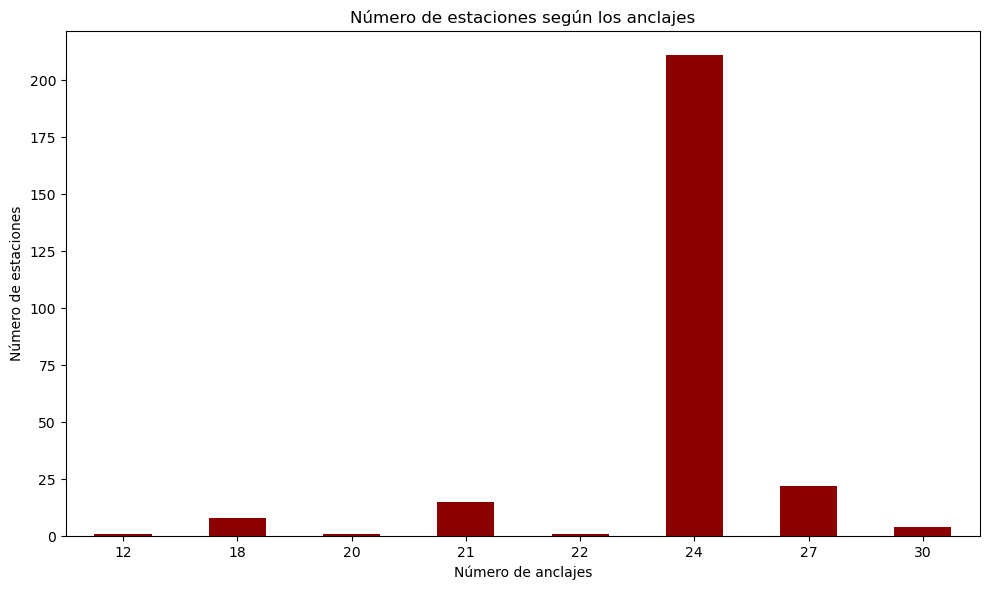

In [106]:
# Agrupar por nº de anclajes y contar estaciones 
conteo_bases = df.groupby('total_bases')['name'].nunique().sort_index()

print("Conteo de estaciones por número de anclajes:")
print(conteo_bases)

# Graficar
fig, ax = plt.subplots(figsize=(10,6))
conteo_bases.plot(kind='bar', ax=ax, color='darkred')
ax.set_xlabel('Número de anclajes')
ax.set_ylabel('Número de estaciones')
ax.set_title('Número de estaciones según los anclajes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('nanclajes.png')
plt.show()

Se muestra el número de estaciones por distrito con el objetivo de analizar cómo se distribuye geográficamente el servicio de BiciMAD dentro de la ciudad. Esta visualización permite identificar posibles desigualdades en la cobertura del sistema, detectar distritos con mayor o menor densidad de estaciones y evaluar si existe una relación entre la disponibilidad del servicio y el nivel de uso observado. 

C:\Users\julia\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


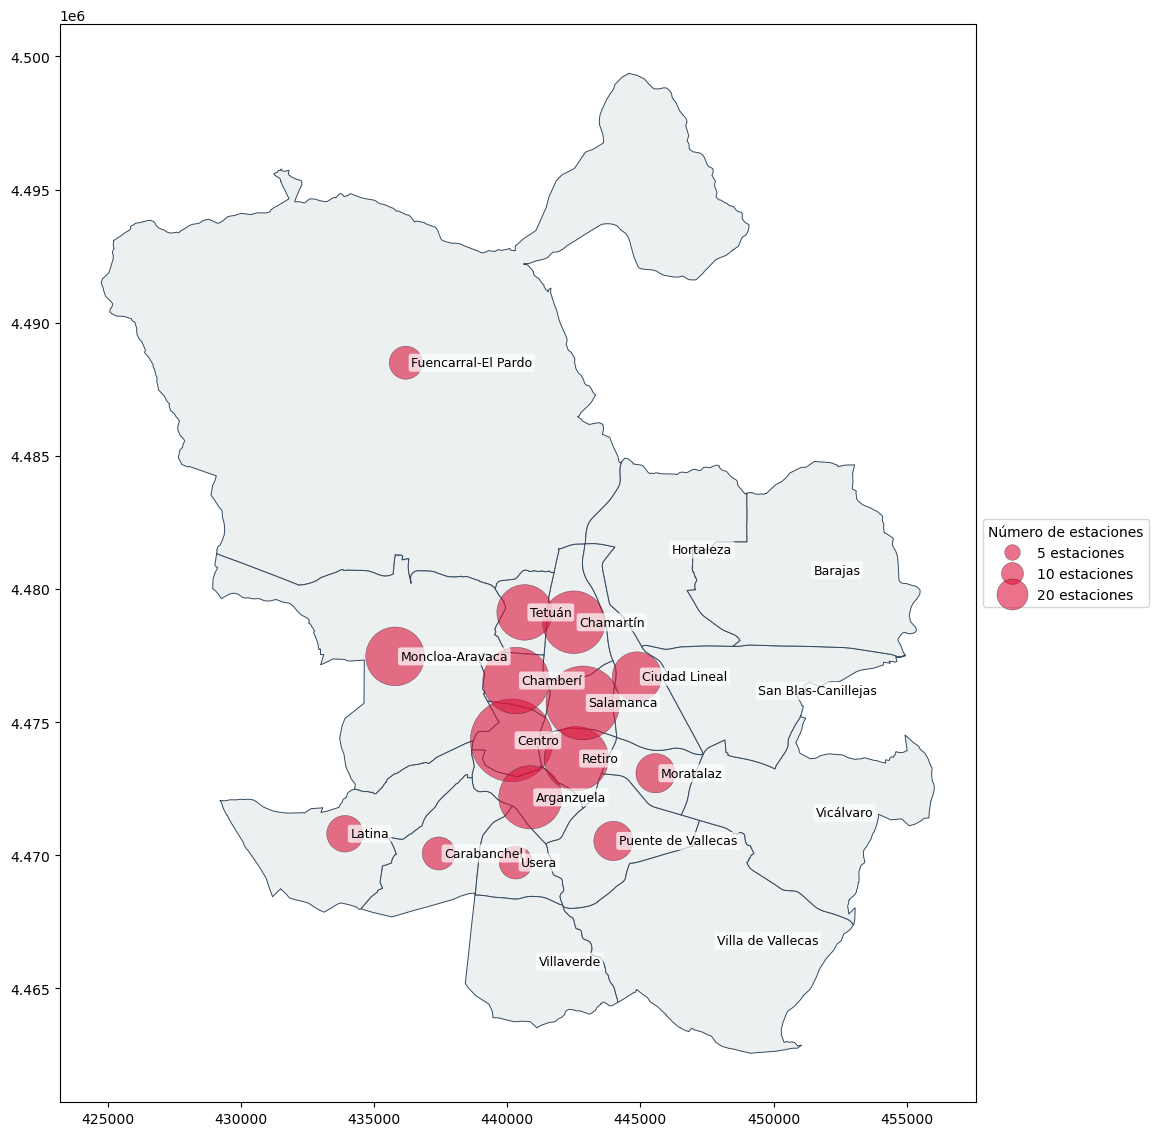

<Figure size 640x480 with 0 Axes>

In [107]:
# Rutas base
base_path = Path().resolve()
output_path = base_path / "OUTPUT"
shp_estaciones_excel = output_path / "estaciones.shp"

# Leer shp de estaciones
gdf_estaciones_excel = gpd.read_file(shp_estaciones_excel)

# Leer shp de distritos, filtrando por Madrid
gdf_madrid = gdf_dist_simp[gdf_dist_simp["CMUN"] == "079"]

# Asegurar que ambos GeoDataFrames usan el mismo SRC
if gdf_estaciones_excel.crs != gdf_madrid.crs:
    gdf_estaciones_excel = gdf_estaciones_excel.to_crs(gdf_madrid.crs)

# Asignar cada estación a su distrito
gdf_estaciones_por_distrito = gpd.sjoin(
    gdf_estaciones_excel, gdf_madrid, how="left", predicate="within"
)

# Contar estaciones por distrito
conteo_estaciones = (
    gdf_estaciones_por_distrito.groupby("CDDISTRI")
    .size()
    .reset_index(name="n_estaciones")
)

# Asegurar que los códigos de distrito son strings con ceros a la izquierda 
gdf_madrid["CDDISTRI"] = gdf_madrid["CDDISTRI"].astype(str).str.zfill(2)
conteo_estaciones["CDDISTRI"] = conteo_estaciones["CDDISTRI"].astype(str).str.zfill(2)

# Unir el conteo al GeoDataFrame original de distritos ---
gdf_madrid = gdf_madrid.merge(conteo_estaciones, on="CDDISTRI", how="left")
gdf_madrid["n_estaciones"] = gdf_madrid["n_estaciones"].fillna(0).astype(int)

# Crear diccionario de distritos
distritos_nombres = {
    "01": "Centro",
    "02": "Arganzuela",
    "03": "Retiro",
    "04": "Salamanca",
    "05": "Chamartín",
    "06": "Tetuán",
    "07": "Chamberí",
    "08": "Fuencarral-El Pardo",
    "09": "Moncloa-Aravaca",
    "10": "Latina",
    "11": "Carabanchel",
    "12": "Usera",
    "13": "Puente de Vallecas",
    "14": "Moratalaz",
    "15": "Ciudad Lineal",
    "16": "Hortaleza",
    "17": "Villaverde",
    "18": "Villa de Vallecas",
    "19": "Vicálvaro",
    "20": "San Blas-Canillejas",
    "21": "Barajas"
}

gdf_madrid["nombre_distrito"] = gdf_madrid["CDDISTRI"].map(distritos_nombres)

# Calcular centroides para los símbolos
gdf_madrid["centroide"] = gdf_madrid.geometry.centroid
gdf_centroides = gpd.GeoDataFrame(
    gdf_madrid[["CDDISTRI", "n_estaciones", "nombre_distrito"]],
    geometry=gdf_madrid["centroide"],
    crs=gdf_madrid.crs
)

# Crear mapa
fig, ax = plt.subplots(figsize=(14, 14))

# Graficar
gdf_madrid.plot(ax=ax, edgecolor="#34495e", facecolor="#ecf0f1", linewidth=0.7)

sizes = np.sqrt(gdf_centroides["n_estaciones"]) * 400
gdf_centroides.plot(
    ax=ax,
    markersize=sizes,
    color="crimson",
    alpha=0.6,
    edgecolor="black",
    linewidth=0.3
)

# Añadir leyenda
for idx, row in gdf_centroides.iterrows():
    x, y = row.geometry.x, row.geometry.y
    nombre = row["nombre_distrito"]
    ax.text(
        x + 200, y,
        nombre,
        fontsize=9,
        ha="left",
        va="center",
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
    )

legend_sizes = [5, 10, 20]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'{size} estaciones',
           markerfacecolor='crimson', markersize=np.sqrt(size)*5, alpha=0.6,
           markeredgecolor='black', markeredgewidth=0.3)
    for size in legend_sizes
]

# Leyenda fuera del mapa
ax.legend(handles=legend_elements, title="Número de estaciones",
          loc='center left', bbox_to_anchor=(1, 0.5))


plt.subplots_adjust(right=0.8) 
plt.savefig('estacion_distrito.png')

plt.show()


ax.legend(handles=legend_elements, title="Número de estaciones", loc="upper right")

# Título y estilo
ax.set_title(
    "Número de estaciones BiciMAD por distrito de Madrid\n(Símbolos proporcionales)",
    fontsize=15,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()

A continuación, se pretende graficar el uso total de bicicletas por cada mes del año 2022 con el objetivo de identificar posibles patrones de estacionalidad en la demanda del servicio BiciMAD. Este análisis permite observar cómo varía el uso a lo largo del año y detectar meses con mayor o menor actividad que puede estar relacionado con factores climáticos, periodos vacacionales o hábitos de movilidad.

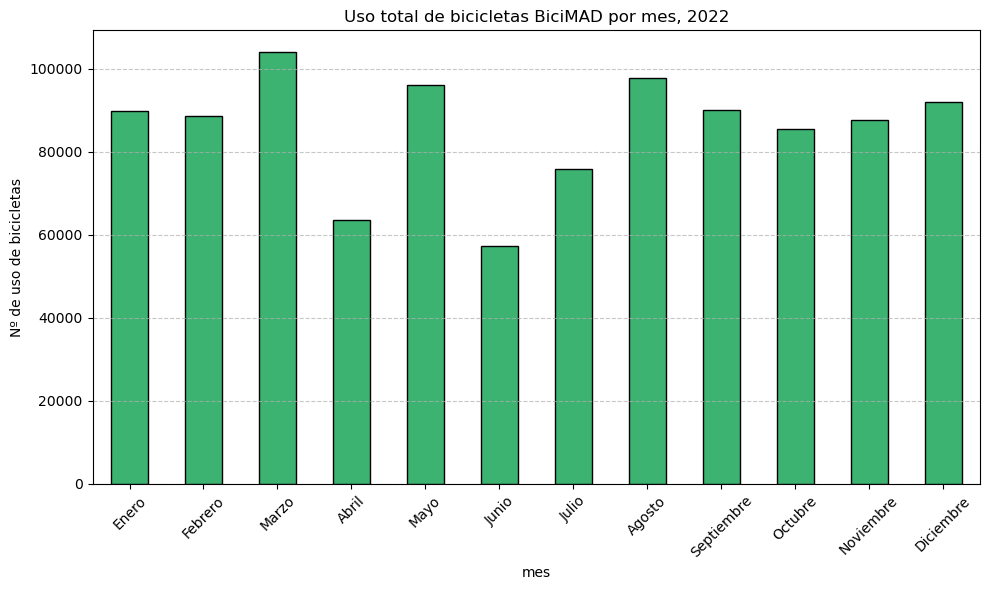

In [108]:
# Diccionario para los nombres de meses
meses_map = {
    '01': 'Enero', '02': 'Febrero', '03': 'Marzo', '04': 'Abril',
    '05': 'Mayo', '06': 'Junio', '07': 'Julio', '08': 'Agosto',
    '09': 'Septiembre', '10': 'Octubre', '11': 'Noviembre', '12': 'Diciembre'
}

dfs = []

for file in excel_files:
    # Extraer el mes desde el nombre del archivo 
    nombre = file.stem  # sin extensión
    mes_num = nombre[4:6]
    mes_nombre = meses_map.get(mes_num, f"Mes {mes_num}")
    
    # Leer archivo y agregar columna de mes
    df = pd.read_excel(file)
    df["mes"] = mes_nombre
    dfs.append(df)

# Concatenar todo
df_concatenado = pd.concat(dfs, ignore_index=True)

# Agrupar por mes y sumar el uso total
uso_mensual = df_concatenado.groupby("mes")["in_use"].sum()

# Ordenar meses en orden cronológico 
uso_mensual = uso_mensual.reindex([
    'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
    'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
])

# Graficar
plt.figure(figsize=(10, 6))
uso_mensual.plot(kind="bar", color="mediumseagreen", edgecolor="black")
plt.title("Uso total de bicicletas BiciMAD por mes, 2022")
plt.ylabel("Nº de uso de bicicletas")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('uso_mes.png')

plt.show()


Ahora bien, dado que cada mes del año tiene una duración distinta —con meses de 28, 30 o 31 días—, para obtener una comparación justa del uso total de bicicletas entre los meses, se ha optado por normalizar los datos. En lugar de utilizar directamente el total mensual, se ha calculado el uso promedio diario, dividiendo el total de usos de cada mes entre el número de días correspondientes. Esta normalización permite identificar tendencias estacionales reales en el comportamiento de los usuarios, eliminando el sesgo que introduciría la mera diferencia en la duración de los meses.

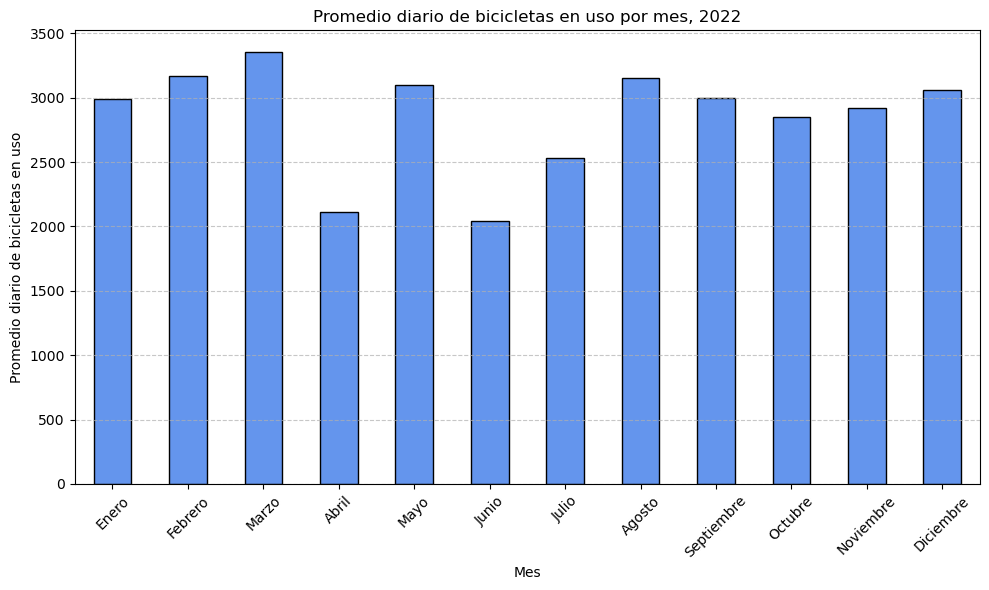

In [109]:
# Convertir la columna de fecha a datetime si no lo está
df_concatenado["timestamp"] = pd.to_datetime(df_concatenado["timestamp"])

# Crear una nueva columna con la fecha para agrupar por día
df_concatenado["fecha"] = df_concatenado["timestamp"].dt.date

# Calcular la suma de 'in_use' por día
uso_diario = df_concatenado.groupby(["mes", "fecha"])["in_use"].sum().reset_index()

# Calcular el promedio diario por mes
promedio_diario_mensual = uso_diario.groupby("mes")["in_use"].mean()

# Ordenar cronológicamente
promedio_diario_mensual = promedio_diario_mensual.reindex([
    'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
    'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
])

# Graficar
plt.figure(figsize=(10, 6))
promedio_diario_mensual.plot(kind="bar", color="cornflowerblue", edgecolor="black")
plt.title("Promedio diario de bicicletas en uso por mes, 2022")
plt.xlabel("Mes")
plt.ylabel("Promedio diario de bicicletas en uso")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('promedio_uso.png')
plt.show()


Con el fin de comprobar si el uso del servicio de bicicletas varía en función del tipo de día (laborales/fines de semana), se ha realizado una división de los datos por día de la semana. Este análisis resulta clave para entrenar un modelo predictivo más preciso ya que permite detectar patrones distintos de comportamiento entre los días hábiles y los de ocio. Identificar estas diferencias permite incorporar variables temporales significativas al modelo con el objeto de ajustar mejor las predicciones de demanda futura.

In [104]:
# Función para clasificar día laboral o fin de semana
def clasificar_dia(dia):
    dias_fin_semana = ['Sábado', 'Domingo']
    if dia in dias_fin_semana:
        return 'Fin de semana'
    else:
        return 'Laboral'

# Agrupar por 'weekday' y sumar 'in_use'
agrupado = df_concatenado.groupby('weekday')['in_use'].sum().reset_index()

# Aplicar clasificación
agrupado['tipo_dia'] = agrupado['weekday'].apply(clasificar_dia)

print(agrupado)

     weekday    in_use       tipo_dia
0    Domingo  144312.5  Fin de semana
1     Jueves  139767.0        Laboral
2      Lunes  146907.5        Laboral
3     Martes  156619.5        Laboral
4  Miércoles  151464.0        Laboral
5     Sábado  145542.0  Fin de semana
6    Viernes  142819.0        Laboral


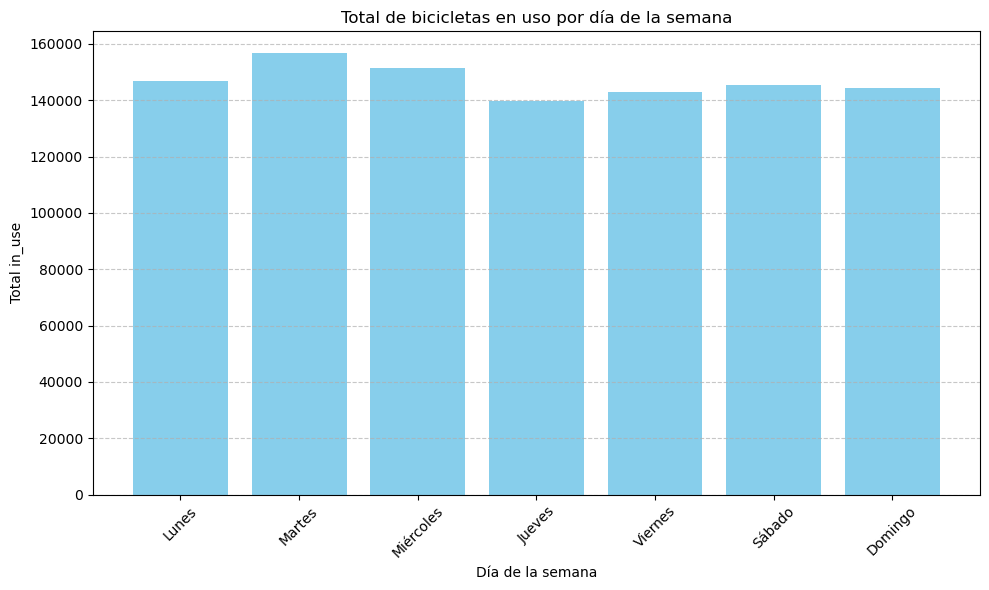

In [105]:
# Ordenar los días de la semana para la gráfica
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
agrupado['weekday'] = pd.Categorical(agrupado['weekday'], categories=orden_dias, ordered=True)
agrupado = agrupado.sort_values('weekday')

plt.figure(figsize=(10,6))
plt.bar(agrupado['weekday'], agrupado['in_use'], color='skyblue')

plt.title('Total de bicicletas en uso por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Total in_use')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


También se precisa importante conocer las estaciones más y menos utilizadas.

name
General Pardiñas                         9649.0
Méndez Álvaro                            8538.0
Banco de España A                        8401.0
Prim                                     7809.5
Fernando el Católico                     7170.0
General Perón con Poeta Joan Maragall    7165.5
General Perón 1                          6922.0
Paseo de la Esperanza                    6772.5
Castellana frente a Hermanos Pinzón      6624.0
Atocha B                                 6167.0
Name: in_use, dtype: float64


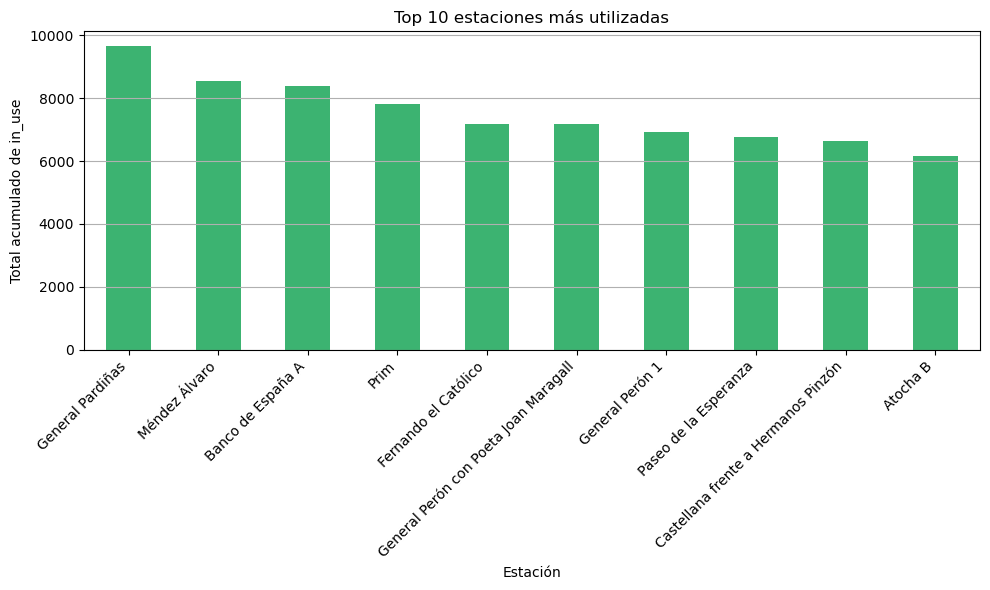

In [110]:
# Agrupar por nombre de estación y sumar el uso total
uso_por_estacion = df_concatenado.groupby('name')['in_use'].sum().sort_values(ascending=False)

# Mostrar las 10 estaciones más utilizadas
print(uso_por_estacion.head(10))

plt.figure(figsize=(10,6))
uso_por_estacion.head(10).plot(kind='bar', color='mediumseagreen')
plt.title('Top 10 estaciones más utilizadas')
plt.xlabel('Estación')
plt.ylabel('Total acumulado de in_use')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('estacion_mas.png')
plt.show()


name
Pº Castellana - Glorieta de Emilio Castelar              262.0
San Germán                                               502.0
Plaza San Francisco                                      537.0
Plaza de Ramales                                         568.0
Red de San Luis A                                       1392.0
Red de San Luis B                                       1392.0
Paseo de la Castellana - Glorieta de Emilio Castelar    1850.5
Remonta                                                 2019.0
Cuatro Caminos 2                                        2106.5
Diego de león                                           2115.5
Name: in_use, dtype: float64


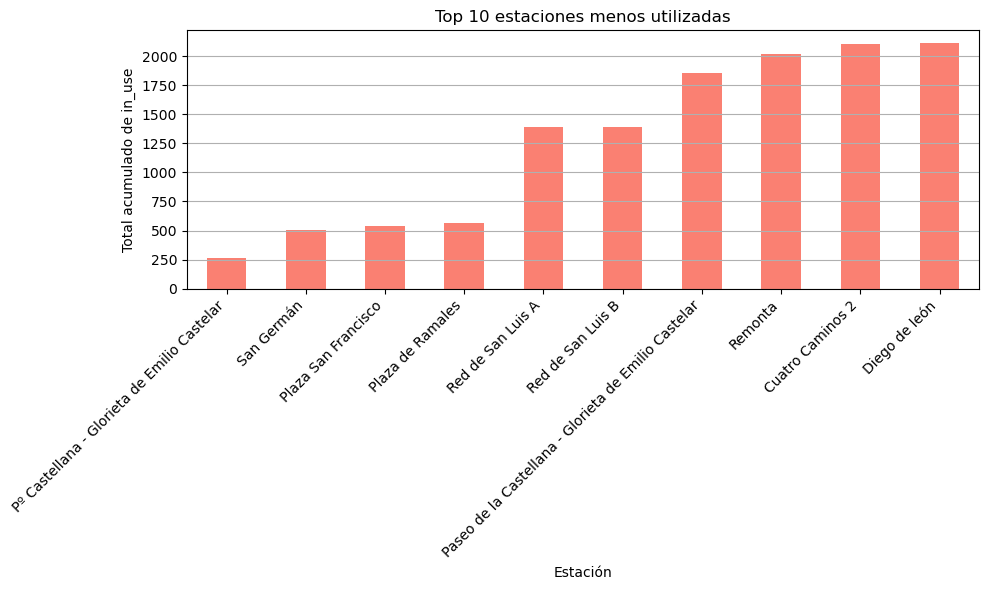

In [111]:
# Agrupar por estación y sumar el uso total
uso_por_estacion = df_concatenado.groupby('name')['in_use'].sum().sort_values(ascending=True)

# Mostrar las 10 menos utilizadas
print(uso_por_estacion.head(10))

plt.figure(figsize=(10,6))
uso_por_estacion.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 estaciones menos utilizadas')
plt.xlabel('Estación')
plt.ylabel('Total acumulado de in_use')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('estacion_menos.png')
plt.show()

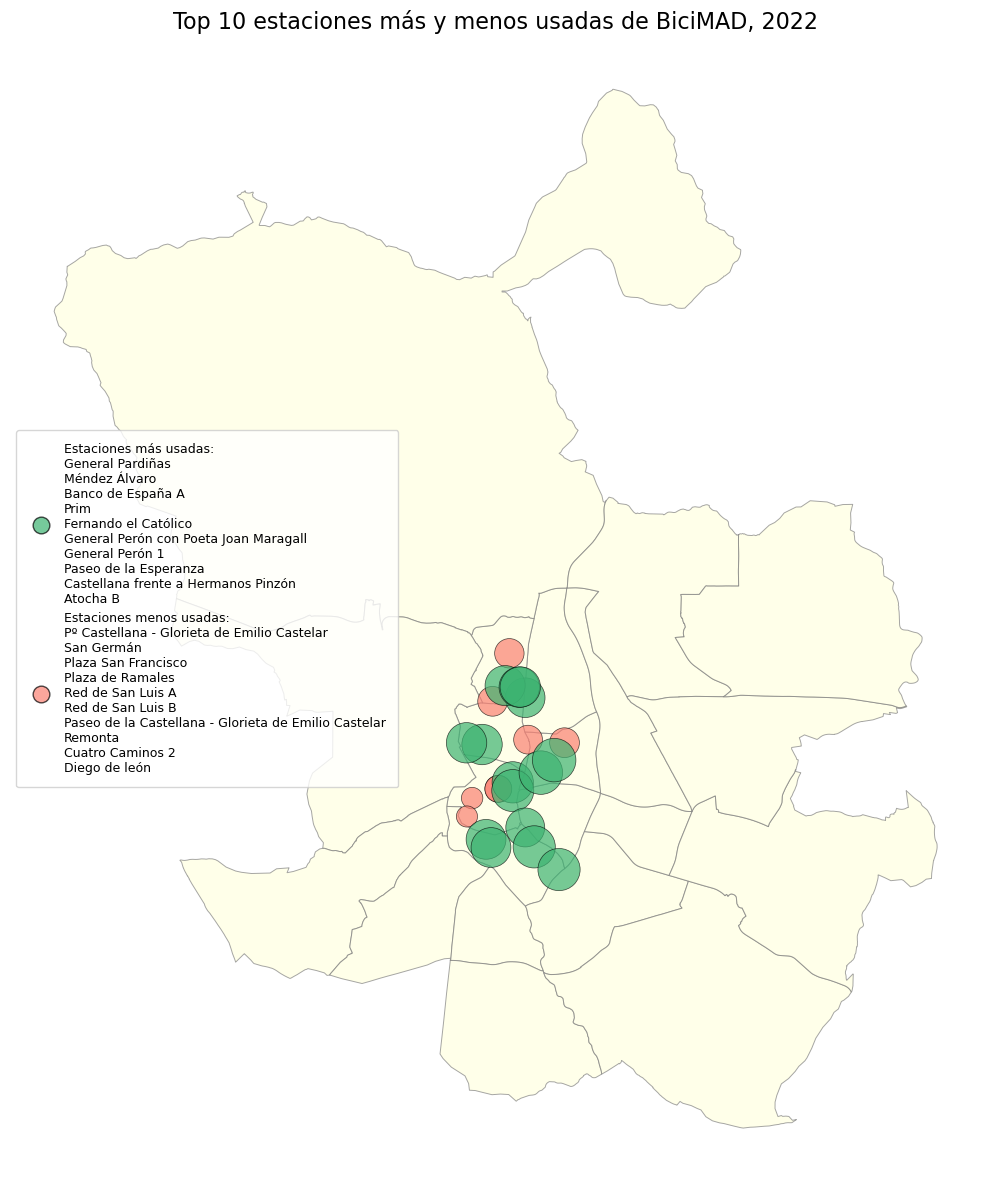

In [ ]:
# 1. Calcular uso total por estación
uso_por_estacion = df_concatenado.groupby('name')['in_use'].sum()

# 2. Obtener top 10 más usadas y top 10 menos usadas
top_10 = uso_por_estacion.sort_values(ascending=False).head(10)
bottom_10 = uso_por_estacion.sort_values(ascending=True).head(10)

# 3. Filtrar GeoDataFrame de estaciones con esos nombres
gdf_top = gdf_estaciones_excel[gdf_estaciones_excel['name'].isin(top_10.index)]
gdf_bottom = gdf_estaciones_excel[gdf_estaciones_excel['name'].isin(bottom_10.index)]

# 4. Añadir columna con uso total para cada GeoDataFrame
gdf_top = gdf_top.merge(top_10.rename('uso_total'), left_on='name', right_index=True)
gdf_bottom = gdf_bottom.merge(bottom_10.rename('uso_total'), left_on='name', right_index=True)

# --- Graficar ---
fig, ax = plt.subplots(figsize=(12, 12))

# Plot distritos primero (fondo)
gdf_madrid.plot(
    ax=ax,
    edgecolor='gray',
    facecolor='lightyellow',
    linewidth=0.7,
    alpha=0.7
)

# Plot estaciones menos usadas (círculos rojos proporcionales)
gdf_bottom.plot(
    ax=ax,
    color='salmon',
    markersize=np.sqrt(gdf_bottom['uso_total']) * 10,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5,
    label='Estaciones menos usadas'
)

# Plot estaciones más usadas (círculos verdes proporcionales)
gdf_top.plot(
    ax=ax,
    color='mediumseagreen',
    markersize=np.sqrt(gdf_top['uso_total']) * 10,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5,
    label='Estaciones más usadas'
)

# No etiquetas en el mapa (se omiten)

# Crear leyenda personalizada con listas de nombres
top_names = "\n".join(top_10.index)
bottom_names = "\n".join(bottom_10.index)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"Estaciones más usadas:\n{top_names}",
           markerfacecolor='mediumseagreen', markersize=12, alpha=0.7, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label=f"Estaciones menos usadas:\n{bottom_names}",
           markerfacecolor='salmon', markersize=12, alpha=0.7, markeredgecolor='black')
]

ax.legend(handles=legend_elements, loc='center left', fontsize=9, frameon=True, fancybox=True, borderpad=1)

ax.set_title("Top 10 estaciones más y menos usadas de BiciMAD, 2022", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()


import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d

# 1. Leer y sumar "in_use" por estación desde Excel
folder = r'C:\Final_Prog\program_final\INPUT\datos_filtrados'
df_total = pd.DataFrame()

for file in os.listdir(folder):
    if file.endswith('.xlsx'):
        df = pd.read_excel(os.path.join(folder, file))
        if {'station_id', 'lat', 'lon', 'in_use'}.issubset(df.columns):
            df_grouped = df.groupby(['station_id', 'lat', 'lon'])['in_use'].sum().reset_index()
            df_total = pd.concat([df_total, df_grouped], ignore_index=True)

# Sumar por estación acumulada
df_sum = df_total.groupby(['station_id', 'lat', 'lon'])['in_use'].sum().reset_index()

# 2. Filtrar las 20 estaciones con mayor uso
top_20 = df_sum.sort_values('in_use', ascending=False).head(20)

# 3. Crear polígonos de Thiessen (Voronoi)
points = top_20[['lon', 'lat']].values
vor = Voronoi(points)

# Crear polígonos válidos desde Voronoi
def voronoi_finite_polygons_2d(vor, radius=None):
    from collections import defaultdict
    from shapely.ops import polygonize
    import numpy as np

    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    all_ridges = defaultdict(list)
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges[p1].append((p2, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if -1 not in vertices:
            new_regions.append([new_vertices[v] for v in vertices])
            continue

        ridges = all_ridges[p1]
        new_region = []
        for p2, v1, v2 in ridges:
            if v2 < 0: v1, v2 = v2, v1
            if v1 >= 0:
                v = vor.vertices[v1]
                new_region.append(v.tolist())
            else:
                t = vor.points[p2] - vor.points[p1]
                t = t / np.linalg.norm(t)
                n = np.array([-t[1], t[0]])
                midpoint = vor.points[[p1, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius
                new_vertices.append(far_point.tolist())
                new_region.append(far_point.tolist())
        new_regions.append(new_region)

    return new_regions

regions = voronoi_finite_polygons_2d(vor)
geoms = [Polygon(r) for r in regions]
gdf_thiessen = gpd.GeoDataFrame(top_20.reset_index(drop=True), geometry=geoms, crs='EPSG:4326')

# 4. Leer shapefile de distritos
gdf_distritos = gpd.read_file(r'C:\Final_Prog\program_final\INPUT\dist2023')

# Asegurar que ambos estén en el mismo sistema de coordenadas
gdf_distritos = gdf_distritos.to_crs(gdf_thiessen.crs)

# 5. Leer CSV de población
pob_df = pd.read_csv(r'C:\Final_Prog\program_final\INPUT\pob_dist.csv')

# Asumimos que el CSV tiene columnas 'distrito' y 'poblacion'
# Ajustar el nombre de columna según shapefile
gdf_distritos = gdf_distritos.merge(pob_df, left_on='NOMBRE', right_on='distrito', how='left')

# 6. Calcular densidad de población (si hay superficie)
if 'Shape_Area' in gdf_distritos.columns:
    gdf_distritos['densidad'] = gdf_distritos['poblacion'] / gdf_distritos['Shape_Area']
else:
    gdf_distritos['densidad'] = gdf_distritos['poblacion'] / gdf_distritos.geometry.area

# 7. Graficar resultado
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_distritos.plot(column='densidad', cmap='OrRd', legend=True, edgecolor='gray', ax=ax)
gdf_thiessen.boundary.plot(ax=ax, color='blue', linewidth=1)
gdf_thiessen.plot(ax=ax, color='none', edgecolor='blue')
top_20_points = gpd.GeoDataFrame(top_20, geometry=gpd.points_from_xy(top_20.lon, top_20.lat), crs='EPSG:4326')
top_20_points.plot(ax=ax, color='black', markersize=20)
ax.set_title('Polígonos de Thiessen sobre densidad poblacional de distritos de Madrid', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
